# 分析思路

## 清理数据



- 每一张表，各自先做初步的清洗然后再合并到一起最终表再作一次清洗，主要是缺失值的处理
- 对建模没作用，无关的字段及时删除，对建模有用，但是不是数值型，编码、分箱处理

## 聚类Kmeans


- 用户分群，打上客户标签簇类值
- 对极大值字段进行归一化处理
- 对聚类K取值进行for循环获取SSE、轮廓系数得分
- 绘制得分曲线图，下降幅度最大则该结尾点为K簇心个数

## 同类群体商品推荐

- 推荐给每个客户的产品，都是他没购买过的
- 同类客户里面，购买数量（次数）最多的那款产品，就属于受欢迎产品
- 同类客户里面，平均购买数量（平均购买次数）最多的那款产品，就属于受欢迎的产品

# 数据导入及删异常值

## 导入数据集

In [29]:
import numpy as np
import pandas as pd
road = r"D:\order.csv"
order=pd.read_csv(road,index_col=0)
order.head(2)

,订单编号,买家会员名,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,...,是否代付,定金排名,修改后的sku,修改后的收货地址,异常信息,天猫卡券抵扣,集分宝抵扣,是否是O2O交易,退款金额,预约门店
0,21407300627014900,1425,58.51,0.0,0,58.51,0,58.51,0,交易成功,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,24270488269081200,2163,15.70,5.0,0,20.70,0,20.70,0,交易成功,...,否,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [3]:
order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3989 entries, 0 to 3988
Data columns (total 45 columns):
订单编号        3989 non-null int64
买家会员名       3989 non-null int64
买家应付货款      3989 non-null float64
买家应付邮费      3989 non-null float64
买家支付积分      3989 non-null int64
总金额         3989 non-null float64
返点积分        3989 non-null int64
买家实际支付金额    3989 non-null float64
买家实际支付积分    3989 non-null int64
订单状态        3989 non-null object
买家留言        384 non-null object
收货人姓名       3989 non-null int64
收货地址        3989 non-null object
运送方式        3989 non-null object
联系电话        142 non-null object
联系手机        3986 non-null object
订单创建时间      3989 non-null object
订单付款时间      3989 non-null object
宝贝标题        3989 non-null object
宝贝种类        3989 non-null int64
物流单号        3988 non-null object
物流公司        3988 non-null object
订单备注        460 non-null object
宝贝总数量       3989 non-null int64
店铺Id        3989 non-null int64
店铺名称        3989 non-null int64
订单关闭原因      3989 non-null object
卖家服务费      

## 删除缺失率90%字段

In [24]:
order.shape

(3989, 45)

In [25]:
order.shape[0]*0.1
# 订单表内3989行83列，删除缺失率较多的字段，则该行总数只有少于10%的数据398行

398.90000000000003

In [30]:
order=order.dropna(axis=1,thresh=order.shape[0]*0.1)     
order.shape
# thresh打谷；锤石；反复做脱粒
# thresh=10 如果字段的非缺失值格式少于10的，该字段删除
# 首先看非缺失值至少多少 --->order.shape[0]*0.1得到非缺失值最少个数（非缺失值个数的临界值）

(3989, 32)

In [9]:
order.describe()

,订单编号,买家会员名,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,收货人姓名,宝贝种类,宝贝总数量,店铺Id,店铺名称,卖家服务费,退款金额
count,3.989000e+03,3989.000000,3989.000000,3989.000000,3989.0,3989.000000,3989.0,3989.000000,3989.0,3989.000000,3989.000000,3989.000000,3989.0,3989.0,3989.0,3989.000000
mean,1.768421e+16,1705.994736,70.403893,2.549586,0.0,72.953480,0.0,72.613673,0.0,1666.074455,5.489346,24.094009,0.0,0.0,0.0,0.339807
std,3.608683e+15,976.186265,113.019072,4.534389,0.0,112.446506,0.0,112.279791,0.0,960.433977,6.222972,46.014933,0.0,0.0,0.0,6.369523
min,4.931300e+15,0.000000,1.000000,0.000000,0.0,1.180000,0.0,0.000000,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.000000
25%,1.502612e+16,870.000000,17.450000,0.000000,0.0,22.090000,0.0,22.080000,0.0,839.000000,1.000000,4.000000,0.0,0.0,0.0,0.000000
50%,1.791438e+16,1716.000000,48.530000,0.000000,0.0,53.070000,0.0,52.320000,0.0,1663.000000,3.000000,10.000000,0.0,0.0,0.0,0.000000
75%,2.035314e+16,2534.000000,77.970000,5.000000,0.0,78.000000,0.0,77.000000,0.0,2498.000000,8.000000,26.000000,0.0,0.0,0.0,0.000000
max,2.428163e+16,3410.000000,3521.000000,200.000000,0.0,3521.000000,0.0,3521.000000,0.0,3327.000000,50.000000,820.000000,0.0,0.0,0.0,315.490000


## 删除一个值字段

In [31]:
order['订单状态'].value_counts()

交易成功    3989
Name: 订单状态, dtype: int64

In [35]:
list(order['卖家服务费'].value_counts().index == 0)

[True]

In [20]:
order['宝贝标题 '].nunique() == 1
# 字段名称有空格，判断是否为一个值则异常
# order['宝贝标题'].nunique() == 0

False

In [27]:
# 都是一样的数值的列没有价值，可删除

for i in order.columns:
    if order[i].nunique()==1:
        print(i)
        # 打印删除的字段名称
        del order[i]
        # 在原表上进行字段删除

order.shape

买家支付积分
返点积分
买家实际支付积分
订单状态
运送方式
店铺Id
店铺名称
订单关闭原因
卖家服务费
买家服务费
是否手机订单
是否上传合同照片
是否上传小票
是否代付


(3989, 18)

In [28]:
order.columns

Index(['订单编号', '买家会员名', '买家应付货款', '买家应付邮费', '总金额', '买家实际支付金额', '收货人姓名', '收货地址',
       '联系手机', '订单创建时间', '订单付款时间 ', '宝贝标题 ', '宝贝种类', '物流单号 ', '物流公司', '订单备注',
       '宝贝总数量', '退款金额'],
      dtype='object')

In [18]:
# 删除字段，邮费，应付付款，姓名，手机号，时间，物流，备注，这些信息对用户群聚类无明显价值
# 订单编号价值在于可进行后期表进行连接使用

order=order[['订单编号','买家会员名','买家实际支付金额','收货地址','宝贝标题 ', '宝贝种类','退款金额','宝贝总数量']]

In [19]:
order.head(2)

,订单编号,买家会员名,买家实际支付金额,收货地址,宝贝标题,宝贝种类,退款金额,宝贝总数量
0,21407300627014900,1425,58.51,广东省 广州市 越秀区 华乐街道环市东路华侨新村光***,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家，特价5号AA普通干电池 电动玩具...,5,0.0,59
1,24270488269081200,2163,20.70,江西省 九江市 浔阳区 甘棠街道浔阳东路108号儿***,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发，创意新款回力小车惯性坦克 军事...,2,0.0,2


# 分类型变量编码

## 退款金额0-1编码

In [37]:
pd.DataFrame(order.退款金额).describe()

# 聚类之前将极大值极小值进行01编码后避免异常值归类问题
# 大部分75%退款金额为0，少部分为真实退货信息

,退款金额
count,3989.000000
mean,0.339807
std,6.369523
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,315.490000


In [38]:
# np.where 满足条件(condition)，输出x，不满足输出y
# 有无退款，有则1 无则0，退款字段影响到每个用户对不同商品的推荐

order.退款金额=np.where(order.退款金额>0,1,0)
order.head(2)

,订单编号,买家会员名,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,...,店铺Id,店铺名称,订单关闭原因,卖家服务费,买家服务费,是否手机订单,是否上传合同照片,是否上传小票,是否代付,退款金额
0,21407300627014900,1425,58.51,0.0,0,58.51,0,58.51,0,交易成功,...,0,0,订单未关闭,0,0元,NaN,否,否,否,0
1,24270488269081200,2163,15.70,5.0,0,20.70,0,20.70,0,交易成功,...,0,0,订单未关闭,0,0元,手机订单,否,否,否,0


In [39]:
order.退款金额.value_counts()

0    3943
1      46
Name: 退款金额, dtype: int64

## 收货地址0-1编码

In [ ]:
list(order.收货地址)

#  '北京 北京市 朝阳区 和平街街道和平西苑10号楼5***'
#  '福建省 三明市 尤溪县 福建省三明市尤溪县埔头工业***'
#  '广西壮族自治区 玉林市 兴业县 沙塘镇平塘沙井村(***',

In [41]:
address=order.收货地址.str[:3]
address

0       广东省
1       江西省
2       浙江省
3       湖南省
4       安徽省
       ... 
3984    海南省
3985    河北省
3986    广东省
3987    海南省
3988    云南省
Name: 收货地址, Length: 3989, dtype: object

In [42]:
address.value_counts()

# 广西壮    110
# 黑龙江    115
# 能区分不同地区即可，出现异常值名称可进行修改

广东省    561
浙江省    340
江苏省    297
福建省    251
山东省    196
河南省    186
湖南省    177
江西省    166
湖北省    159
四川省    157
安徽省    142
河北省    140
上海     129
黑龙江    115
山西省    115
广西壮    110
北京     109
辽宁省    104
云南省     98
贵州省     84
重庆      84
吉林省     70
陕西省     69
海南省     58
天津      49
内蒙古     15
新疆维      5
甘肃省      2
青海省      1
Name: 收货地址, dtype: int64

In [ ]:
# address.value_counts().index[12] = '上海市'

# TypeError: Index does not support mutable operations

In [50]:
# 广西壮族自治区

pd.DataFrame(['广西壮']).apply(lambda x:x+'广西壮族自治区')

,0
0,广西壮广西壮族自治区


In [51]:
# 自治区自治区

pd.DataFrame(['自治区']).apply(lambda x:x+'自治区')

,0
0,自治区自治区


In [52]:
# 新疆维吾尔自治区

pd.DataFrame(['新疆维']).apply(lambda x:x+'吾尔自治区')

,0
0,新疆维吾尔自治区


In [47]:
pd.DataFrame(['黑龙江']).apply(lambda x:x+'省')

,0
0,黑龙江省


In [49]:
pd.DataFrame(['上海','北京','天津','重庆']).apply(lambda x:x+'市')

,0
0,上海市
1,北京市
2,天津市
3,重庆市


In [60]:
address=address.str.get_dummies()
# 不同字段生成不同 00001000 0-1处理
# 生成结果为pandas类型，可对columns列名进行重命名
address.head()

,上海,云南省,内蒙古,北京,吉林省,四川省,天津,安徽省,山东省,山西省,...,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,青海省,黑龙江
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
address.columns

Index(['上海 ', '云南省', '内蒙古', '北京 ', '吉林省', '四川省', '天津 ', '安徽省', '山东省', '山西省',
       '广东省', '广西壮', '新疆维', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省',
       '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省', '重庆 ', '陕西省', '青海省', '黑龙江'],
      dtype='object')

In [63]:
address.columns = ['上海市', '云南省', '内蒙古自治区', '北京市', '吉林省', '四川省', '天津市', '安徽省', '山东省', '山西省',
       '广东省', '广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省',
       '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省', '重庆市', '陕西省', '青海省', '黑龙江省']

address.columns

Index(['上海市', '云南省', '内蒙古自治区', '北京市', '吉林省', '四川省', '天津市', '安徽省', '山东省', '山西省',
       '广东省', '广西壮族自治区', '新疆维吾尔自治区', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省',
       '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省', '重庆市', '陕西省', '青海省', '黑龙江省'],
      dtype='object')

In [64]:
# 对这类0-1编码后生成的新字段，字段名添加一个“记号”：

address.columns="地址_"+address.columns
address

,地址_上海市,地址_云南省,地址_内蒙古自治区,地址_北京市,地址_吉林省,地址_四川省,地址_天津市,地址_安徽省,地址_山东省,地址_山西省,...,地址_湖北省,地址_湖南省,地址_甘肃省,地址_福建省,地址_贵州省,地址_辽宁省,地址_重庆市,地址_陕西省,地址_青海省,地址_黑龙江省
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 宝贝种类0-1编码

In [66]:
order.宝贝种类.value_counts()
# 1     1529
# 2      299
# 3      254
# 4      244

In [70]:
len(order.宝贝种类.value_counts().index)

48

In [81]:
order.宝贝种类.astype(str).str.get_dummies()
# 接受字符串类型 需要将int转为string
# AttributeError: Can only use .str accessor with string values!

,1,10,11,12,13,14,15,16,17,18,...,46,47,48,49,5,50,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3987,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
kinds=order.宝贝种类.astype(str).str.get_dummies()
kinds.head()

,1,10,11,12,13,14,15,16,17,18,...,46,47,48,49,5,50,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
kinds.columns='宝贝种类_'+kinds.columns
kinds.head()

,宝贝种类_1,宝贝种类_10,宝贝种类_11,宝贝种类_12,宝贝种类_13,宝贝种类_14,宝贝种类_15,宝贝种类_16,宝贝种类_17,宝贝种类_18,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 合并表-地址编码-种类编码

In [85]:
order.drop(['收货地址','宝贝种类'],axis=1,inplace=True)

order=pd.concat([order,address,kinds],axis=1)

order.head(2)

,订单编号,买家会员名,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
0,21407300627014900,1425,58.51,0.0,0,58.51,0,58.51,0,交易成功,...,0,0,0,0,1,0,0,0,0,0
1,24270488269081200,2163,15.70,5.0,0,20.70,0,20.70,0,交易成功,...,0,0,0,0,0,0,0,0,0,0


In [86]:
order.isnull().sum()

订单编号       0
买家会员名      0
买家应付货款     0
买家应付邮费     0
买家支付积分     0
          ..
宝贝种类_50    0
宝贝种类_6     0
宝贝种类_7     0
宝贝种类_8     0
宝贝种类_9     0
Length: 107, dtype: int64

# 订单详情表清洗

In [87]:
roaddetail = r"D:\Items_order.csv"
order_detail=pd.read_csv(roaddetail)
order_detail.head(2)

,订单编号,标题,价格,购买数量,外部系统编号,商品属性,套餐信息,备注,订单状态,商家编码
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,WY013-2SZD0426,颜色分类：小号,NaN,NaN,交易成功,WY013-2SZD0426
1,21407300627014900,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20,HT-5H0094,NaN,NaN,NaN,交易成功,HT-5H0094


In [88]:
order_detail=order_detail.dropna(axis=1,thresh=order_detail.shape[0]*0.1) 
order_detail.shape
# 删除列1axis字段，字段的行0列1，行的数量为10%，则删除该字段
# thresh=10 如果字段的非缺失值格式少于10的，该字段删除

(21897, 8)

In [89]:
for i in order_detail.columns:
    if order_detail[i].nunique()==1:
        del order_detail[i]

order_detail.shape

# 删除数值结果只有1个的，代入聚类算法无价值，进行删除处理

(21897, 8)

In [90]:
order_detail.columns

Index(['订单编号', '标题', '价格', '购买数量', '外部系统编号', '商品属性', '订单状态', '商家编码'], dtype='object')

In [91]:
order_detail=order_detail[['订单编号', '标题', '价格', '购买数量']]
order_detail.head(2)

,订单编号,标题,价格,购买数量
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12
1,21407300627014900,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20


In [92]:
order_detail.isnull().sum()

订单编号    0
标题      0
价格      0
购买数量    0
dtype: int64

# 商品详情表清洗

In [94]:
roaditem = r"D:\Items_attribute.csv"
item_detail=pd.read_csv(roaditem)
item_detail.head(2)

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.9,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.9,其它玩具,"3岁,4岁,5岁,6岁",3


## 缺失值处理

In [95]:
item_detail.isnull().sum()

宝贝ID     0
标题       0
价格       0
玩具类型    36
适用年龄     4
品牌       0
dtype: int64

In [96]:
item_detail.玩具类型.value_counts()

其它玩具       165
塑胶玩具        27
其他          24
电玩具         11
仿真生活家电       9
普通娃娃         5
拼搭积木         3
单杆手推玩具       2
仿真医生玩具       1
仿真房间/家具      1
发泄           1
娃娃玩具         1
陀螺           1
仿真厨房类        1
Name: 玩具类型, dtype: int64

# 年龄字段填补缺失值

In [97]:
item_detail.适用年龄.mode()

0    3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁
dtype: object

In [105]:
item_detail.适用年龄.value_counts()
# 3岁的选择mode最多
# 3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁             54
# 3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁                     36
# 3岁,4岁,5岁,6岁                                          36
# 2岁,3岁,4岁,5岁,6岁                                       30

In [102]:
item_detail.适用年龄.isnull().sum()

4

In [103]:
item_detail.适用年龄=item_detail.适用年龄.fillna(item_detail.适用年龄.mode()[0])
item_detail.head(2)

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.9,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.9,其它玩具,"3岁,4岁,5岁,6岁",3


In [104]:
item_detail.isnull().sum()

宝贝ID     0
标题       0
价格       0
玩具类型    36
适用年龄     0
品牌       0
dtype: int64

## 年龄字段分箱

In [32]:
item_detail.适用年龄.nunique()
# nunique() 方法用于获取 'Team’列中所有唯一值的数量

43

In [106]:
df=pd.DataFrame({'A':[1,1,2],'B':[4,5,6]})
df.nunique()

A    2
B    3
dtype: int64

In [33]:
item_detail.适用年龄

0                                   3岁,4岁,5岁,6岁
1                                   3岁,4岁,5岁,6岁
2              3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁
3      3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁
4                                         3岁,4岁
                         ...                   
283    3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁,13岁,14岁
284                              3岁,4岁,5岁,6岁,7岁
285                               6个月,12个月,18个月
286            3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁
287            3岁,4岁,5岁,6岁,7岁,8岁,9岁,10岁,11岁,12岁
Name: 适用年龄, Length: 288, dtype: object

In [107]:
age=item_detail.适用年龄.str.split(',')    # 对Series里面的字符串进行拆分
age  

0                                       [3岁, 4岁, 5岁, 6岁]
1                                       [3岁, 4岁, 5岁, 6岁]
2            [3岁, 4岁, 5岁, 6岁, 7岁, 8岁, 9岁, 10岁, 11岁, 12岁]
3      [3岁, 4岁, 5岁, 6岁, 7岁, 8岁, 9岁, 10岁, 11岁, 12岁, 13...
4                                               [3岁, 4岁]
                             ...                        
283    [3岁, 4岁, 5岁, 6岁, 7岁, 8岁, 9岁, 10岁, 11岁, 12岁, 13...
284                                 [3岁, 4岁, 5岁, 6岁, 7岁]
285                                    [6个月, 12个月, 18个月]
286          [3岁, 4岁, 5岁, 6岁, 7岁, 8岁, 9岁, 10岁, 11岁, 12岁]
287          [3岁, 4岁, 5岁, 6岁, 7岁, 8岁, 9岁, 10岁, 11岁, 12岁]
Name: 适用年龄, Length: 288, dtype: object

In [109]:
age[0],age[0][0]

(['3岁', '4岁', '5岁', '6岁'], '3岁')

In [110]:
a=set()
# 集合可自动去重处理
for i in age:
    for j in i:
        a.add(j)
        
a

{'10岁',
 '11岁',
 '12个月',
 '12岁',
 '13岁',
 '14岁',
 '14岁以上',
 '18个月',
 '2岁',
 '3个月',
 '3岁',
 '4岁',
 '5岁',
 '6个月',
 '6岁',
 '7岁',
 '8岁',
 '9岁'}

对上面的年龄标签作分类：

In [111]:
baby=['3个月','6个月', '12个月']
little_child=['18个月','2岁','3岁']
child=['4岁','5岁','6岁','7岁']

# '幼儿|学前'
def change(x):
    a=''
    for i in x:                    # 对age里面列表的年龄元素抽出来
        if i in baby:              # 判断这个年龄元素是否属于baby范围
            if '婴儿|' in a:       # 如果年龄元素属于baby，再判断字符串a是否已经打好了“婴儿|”这个标记
                continue           # 如果“婴儿|”这个标签已经在字符串a里面，就跳过for循环一次，不再添加“婴儿|”
            a+='婴儿|'              # 如果“婴儿|”这个标签还没在字符串a里面，就添加“婴儿|”进字符串a里面
        elif i in little_child:
            if "幼儿|" in a:
                continue
            a+='幼儿|'
        elif i in child:
            if "学前|" in a:
                continue
            a+='学前|'
        else:
            if "学生|" in a:
                continue
            a+='学生|'
    return a


age=age.apply(change)
age

0         幼儿|学前|
1         幼儿|学前|
2      幼儿|学前|学生|
3      幼儿|学前|学生|
4         幼儿|学前|
         ...    
283    幼儿|学前|学生|
284       幼儿|学前|
285       婴儿|幼儿|
286    幼儿|学前|学生|
287    幼儿|学前|学生|
Name: 适用年龄, Length: 288, dtype: object

## 年龄字段0-1编码

In [112]:
age.str.get_dummies('|')

,婴儿,学前,学生,幼儿
0,0,1,0,1
1,0,1,0,1
2,0,1,1,1
3,0,1,1,1
4,0,1,0,1
...,...,...,...,...
283,0,1,1,1
284,0,1,0,1
285,1,0,0,1
286,0,1,1,1


In [113]:
age=age.str.get_dummies('|')

In [114]:
age

,婴儿,学前,学生,幼儿
0,0,1,0,1
1,0,1,0,1
2,0,1,1,1
3,0,1,1,1
4,0,1,0,1
...,...,...,...,...
283,0,1,1,1
284,0,1,0,1
285,1,0,0,1
286,0,1,1,1


In [115]:
age=age[['婴儿','幼儿','学前','学生']]

age

,婴儿,幼儿,学前,学生
0,0,1,1,0
1,0,1,1,0
2,0,1,1,1
3,0,1,1,1
4,0,1,1,0
...,...,...,...,...
283,0,1,1,1
284,0,1,1,0
285,1,1,0,0
286,0,1,1,1


In [116]:
age.columns='年龄段_'+age.columns
age

,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生
0,0,1,1,0
1,0,1,1,0
2,0,1,1,1
3,0,1,1,1
4,0,1,1,0
...,...,...,...,...
283,0,1,1,1
284,0,1,1,0
285,1,1,0,0
286,0,1,1,1


# 品牌字段0-1编码

In [117]:
brand=item_detail.品牌.astype(str).str.get_dummies()

In [118]:
brand.head()

,0,1,10,11,12,13,14,15,16,17,...,20,21,22,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [119]:
brand.columns='品牌_'+brand.columns
brand.head()

,品牌_0,品牌_1,品牌_10,品牌_11,品牌_12,品牌_13,品牌_14,品牌_15,品牌_16,品牌_17,...,品牌_20,品牌_21,品牌_22,品牌_3,品牌_4,品牌_5,品牌_6,品牌_7,品牌_8,品牌_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# 合并订单表

## 商品明细表+年龄01+品牌01

In [121]:
item_detail.head(2)

,宝贝ID,标题,价格,玩具类型,适用年龄,品牌
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.9,塑胶玩具,"3岁,4岁,5岁,6岁",3
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.9,其它玩具,"3岁,4岁,5岁,6岁",3


删除转码前的字段：

In [122]:
item_detail.drop(['玩具类型','适用年龄','品牌'],axis=1,inplace=True)

In [123]:
item_detail.head(2)

,宝贝ID,标题,价格
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.9
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.9


把上面删除完多余字段的表与前面转码完成后的表横向合并：

In [124]:
item_detail=pd.concat([item_detail,age,brand],axis=1)
item_detail.head()

,宝贝ID,标题,价格,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,品牌_1,品牌_10,...,品牌_20,品牌_21,品牌_22,品牌_3,品牌_4,品牌_5,品牌_6,品牌_7,品牌_8,品牌_9
0,537396783238,创意新款回力小车惯性坦克 军事儿童玩具模型地摊货源玩具车批发,8.90,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,36286235128,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,3.90,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35722000205,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,1.65,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,550659732532,新款创意六一儿童节礼物音乐投影电动枪夜市地摊货源批发男孩玩具,9.90,0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,531877266868,发条玩具批发上链卡通动物青蛙儿童礼物宝宝玩具经典80后益智地摊,1.85,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 保留有订单的商品明细表

In [125]:
order_detail.columns

Index(['订单编号', '标题', '价格', '购买数量'], dtype='object')

In [129]:
item_detail.columns

Index(['宝贝ID', '标题', '价格', '年龄段_婴儿', '年龄段_幼儿', '年龄段_学前', '年龄段_学生', '品牌_0',
       '品牌_1', '品牌_10', '品牌_11', '品牌_12', '品牌_13', '品牌_14', '品牌_15', '品牌_16',
       '品牌_17', '品牌_18', '品牌_19', '品牌_2', '品牌_20', '品牌_21', '品牌_22', '品牌_3',
       '品牌_4', '品牌_5', '品牌_6', '品牌_7', '品牌_8', '品牌_9'],
      dtype='object')

In [130]:
# merge合并；融合；归并
# 订单表和商品详情表合并
# 订单信息和被哪些年龄段人买了及该订单标题商品属于哪个品牌分类
# 存在订单表数据，则一定有商品详细信息，但有商品详细信息不一定有订单数据
# inner则只保留两者都存在的信息，去除商品详细信息没购买记录的

table_01=pd.merge(order_detail,item_detail,on='标题',how='inner')
table_01.head()

,订单编号,标题,价格_x,购买数量,宝贝ID,价格_y,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,...,品牌_20,品牌_21,品牌_22,品牌_3,品牌_4,品牌_5,品牌_6,品牌_7,品牌_8,品牌_9
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,530449665002,0.58,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
1,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,1,530449665002,0.58,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
2,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,1,530449665002,0.58,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,50,530449665002,0.58,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,50,530449665002,0.58,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0


In [131]:
table_01.shape

(19943, 33)

In [132]:
# 订单表及商品明细表去重处理
# duplicates重复；复制；双折；使成双

table_01.drop_duplicates().shape

(17999, 33)

In [133]:
table_01=table_01.drop_duplicates()

删除重复多余的字段：

In [134]:
table_01.drop('价格_y',axis=1,inplace=True)

In [135]:
table_01=table_01.rename(columns={'价格_x':'价格'})
table_01.head()

,订单编号,标题,价格,购买数量,宝贝ID,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,...,品牌_20,品牌_21,品牌_22,品牌_3,品牌_4,品牌_5,品牌_6,品牌_7,品牌_8,品牌_9
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,530449665002,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,1,530449665002,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
2,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,1,530449665002,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
3,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.68,50,530449665002,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,20885882368182100,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,50,530449665002,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0


## 订单商品明细表连接

订单表order存有所有的订单编号（不重复），table_01表的订单编号（有重复，同一个订单号购买多类商品导致）

In [136]:
order.columns

Index(['订单编号', '买家会员名', '买家应付货款', '买家应付邮费', '买家支付积分', '总金额', '返点积分',
       '买家实际支付金额', '买家实际支付积分', '订单状态',
       ...
       '宝贝种类_46', '宝贝种类_47', '宝贝种类_48', '宝贝种类_49', '宝贝种类_5', '宝贝种类_50',
       '宝贝种类_6', '宝贝种类_7', '宝贝种类_8', '宝贝种类_9'],
      dtype='object', length=107)

In [137]:
table_01.columns

Index(['订单编号', '标题', '价格', '购买数量', '宝贝ID', '年龄段_婴儿', '年龄段_幼儿', '年龄段_学前',
       '年龄段_学生', '品牌_0', '品牌_1', '品牌_10', '品牌_11', '品牌_12', '品牌_13', '品牌_14',
       '品牌_15', '品牌_16', '品牌_17', '品牌_18', '品牌_19', '品牌_2', '品牌_20', '品牌_21',
       '品牌_22', '品牌_3', '品牌_4', '品牌_5', '品牌_6', '品牌_7', '品牌_8', '品牌_9'],
      dtype='object')

In [138]:
order_tag=pd.merge(table_01,order,on='订单编号',how='left')
order_tag.shape

(17999, 138)

In [140]:
order_tag.head(2)

,订单编号,标题,价格,购买数量,宝贝ID,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
0,21407300627014900,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12,530449665002,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,24043728806509300,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,1,530449665002,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
len(order_tag.isnull().sum()[order_tag.isnull().sum()==0].index)

133

In [139]:
# order_tag.isnull().sum()[order_tag_02.isnull().sum()!=0]
order_tag.isnull().sum()[order_tag.isnull().sum()!=0]

联系手机          7
物流单号          1
物流公司          1
订单备注      15307
是否手机订单     1101
dtype: int64

In [144]:
order_tag.drop(['订单编号','标题','宝贝ID','宝贝标题 '],axis=1,inplace=True)
order_tag.head()

,价格,购买数量,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,品牌_1,品牌_10,品牌_11,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
0,0.58,12,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.58,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.68,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.68,50,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.58,50,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
order_tag.columns

Index(['价格', '购买数量', '年龄段_婴儿', '年龄段_幼儿', '年龄段_学前', '年龄段_学生', '品牌_0', '品牌_1',
       '品牌_10', '品牌_11',
       ...
       '宝贝种类_46', '宝贝种类_47', '宝贝种类_48', '宝贝种类_49', '宝贝种类_5', '宝贝种类_50',
       '宝贝种类_6', '宝贝种类_7', '宝贝种类_8', '宝贝种类_9'],
      dtype='object', length=110)

In [145]:
order_tag=order_tag.groupby('买家会员名').sum()
order_tag.head()

,价格,购买数量,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,品牌_1,品牌_10,品牌_11,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
买家会员名,,,,,,,,,,,,,,,,,,,,,
0,9.90,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.83,8,0,4,4,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7.45,15,0,2,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.04,2,0,2,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27.91,6,0,6,6,6,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0


In [146]:
order_tag.shape

(3318, 119)

# 归一化

In [147]:
order_tag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3410
Columns: 119 entries, 价格 to 宝贝种类_9
dtypes: float64(5), int32(1), int64(113)
memory usage: 3.0 MB


In [148]:
order_tag.head(2)

,价格,购买数量,年龄段_婴儿,年龄段_幼儿,年龄段_学前,年龄段_学生,品牌_0,品牌_1,品牌_10,品牌_11,...,宝贝种类_46,宝贝种类_47,宝贝种类_48,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9
买家会员名,,,,,,,,,,,,,,,,,,,,,
0,9.90,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.83,8,0,4,4,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
order_tag.isnull().sum()[order_tag.isnull().sum()!=0]

Series([], dtype: int64)

In [150]:
(order_tag.isnull().sum()!=0).sum()

0

## 将数据集转数组

In [172]:
# 归一化API接口接受axis=0 行值 每一行的值  axis=1 列值 每一列的值
# 默认为axis=0 每一行的单个值进行处理 即第一列字段的所有值
data = order_tag.values
data

array([[ 9.9 ,  1.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [19.83,  8.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 7.45, 15.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [23.75,  7.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [17.45,  2.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [27.55,  5.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

## 调用归一化算法进行字段归一

In [152]:
from sklearn.preprocessing import MinMaxScaler

In [173]:
mns = MinMaxScaler()
data_norm = mns.fit_transform(data)
data_norm

# 做了onehot编码的品牌分类和年龄分类，的每一个字段，都进行归一化处理

array([[0.02022514, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04069767, 0.00473293, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01517401, 0.00946586, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04877948, 0.0040568 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03579086, 0.00067613, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05661389, 0.00270453, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# kmeans聚类

- 确认K值
- 业务经验；
- 通过SSE-簇内误差平方差绘图曲线找拐点
- 轮廓系数方法

In [175]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE簇内误差平方和评估

In [176]:
sse = []

for k in range(1,25):
    km = KMeans(n_clusters=k)
    km.fit(data_norm)
    sse.append(km.inertia_)
    
sse

[953.3527851257197,
 840.3908058526431,
 764.2254162695119,
 719.9670501958116,
 665.6205993840016,
 633.0962136866841,
 592.9818134642791,
 556.0239606687417,
 512.4155787663511,
 496.10802995132923,
 447.872770228294,
 428.3027223892049,
 404.9433760834065,
 386.049637714591,
 359.063845670822,
 338.02140018260803,
 317.68025606078675,
 309.676335778183,
 288.43817966343613,
 280.54978795670297,
 259.4713301618923,
 253.70103523798366,
 246.60294015121306,
 234.3418550000075]

## 绘制所有K-SSE直线图

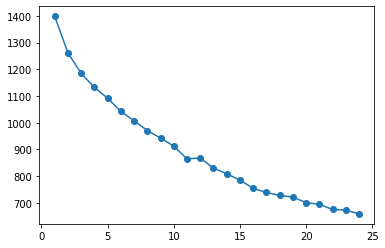

In [77]:
plt.plot(range(1,25),sse,marker='o');

# K值到达20以上SSE无法接近0，则需检查预处理中加入大量无关字段
# 下降缓慢，未出现急剧下降K在3-5之间情况
# 聚类模型对变量太多结果无效，可删除一些特征后进行聚类

## 变量过多影响下降陡峭曲线

In [177]:
a=[]
# 将地址 年龄 品牌 地址 相关字段的01编码数据进行删除
for i in order_tag.columns:
    if i.find("地址")!=-1 or i.find("品牌")!=-1 or i.find("宝贝种类")!=-1 or i.find("年龄")!=-1:
        a.append(i)
print(a)

['年龄段_婴儿', '年龄段_幼儿', '年龄段_学前', '年龄段_学生', '宝贝种类_1', '宝贝种类_10', '宝贝种类_11', '宝贝种类_12', '宝贝种类_13', '宝贝种类_14', '宝贝种类_15', '宝贝种类_16', '宝贝种类_17', '宝贝种类_18', '宝贝种类_19', '宝贝种类_2', '宝贝种类_20', '宝贝种类_21', '宝贝种类_22', '宝贝种类_23', '宝贝种类_24', '宝贝种类_25', '宝贝种类_26', '宝贝种类_27', '宝贝种类_28', '宝贝种类_29', '宝贝种类_3', '宝贝种类_30', '宝贝种类_31', '宝贝种类_32', '宝贝种类_33', '宝贝种类_34', '宝贝种类_35', '宝贝种类_36', '宝贝种类_37', '宝贝种类_38', '宝贝种类_39', '宝贝种类_4', '宝贝种类_40', '宝贝种类_41', '宝贝种类_43', '宝贝种类_45', '宝贝种类_46', '宝贝种类_47', '宝贝种类_48', '宝贝种类_49', '宝贝种类_5', '宝贝种类_50', '宝贝种类_6', '宝贝种类_7', '宝贝种类_8', '宝贝种类_9']


## 删除影响SSE字段后再归一

In [ ]:
# 删除能明显降低SSE的字段
order_tag.drop(a,axis=1,inplace=True)
data=order_tag.values

In [179]:
data

array([[  9.9 ,   1.  ,   9.9 , ...,   0.  ,   0.  ,   0.  ],
       [ 19.83,   8.  , 130.24, ...,   0.  ,   0.  ,   0.  ],
       [  7.45,  15.  , 117.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [ 23.75,   7.  ,  72.3 , ...,   0.  ,   0.  ,   0.  ],
       [ 17.45,   2.  ,  62.  , ...,   0.  ,   0.  ,   0.  ],
       [ 27.55,   5.  , 125.05, ...,   0.  ,   0.  ,   0.  ]])

In [180]:
mns = MinMaxScaler()
data_norm = mns.fit_transform(data)
data_norm

array([[0.02022514, 0.        , 0.0002344 , ..., 0.        , 0.        ,
        0.        ],
       [0.04069767, 0.00473293, 0.00340383, ..., 0.        , 0.        ,
        0.        ],
       [0.01517401, 0.00946586, 0.00305512, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04877948, 0.0040568 , 0.00187785, ..., 0.        , 0.        ,
        0.        ],
       [0.03579086, 0.00067613, 0.00160657, ..., 0.        , 0.        ,
        0.        ],
       [0.05661389, 0.00270453, 0.00326714, ..., 0.        , 0.        ,
        0.        ]])

## 绘制删除字段后的SSE图

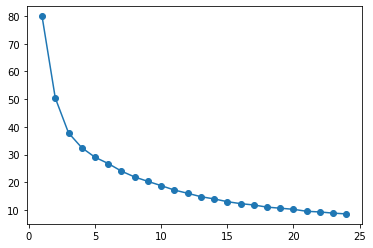

In [181]:
sse = []

for k in range(1,25):
    km = KMeans(n_clusters=k)
    km = km.fit(data_norm)
    sse.append(km.inertia_)
    
sse

plt.plot(range(1,25),sse,marker='o');

- 曲线图可知，在3-5范围的簇心K数量，较好的对Kmeans的选择
- 具体取值3还是4还是5，可再看看轮廓系数
- 通过簇心越紧凑，簇外越离散，则是更好的K值

# 轮廓系数评估

- 考虑了族内族外量方面的因素，系数越大越好
- 使用轮廓系数，族数量必须大于等于2
- SC系数(Silhouette Cofficient)轮廓系数法
- 评估标准描述：结合了聚类的凝聚度(Cohesion)和分离度(Separation),用于评估聚类算法的效果


- 每次聚类之后，每一个样本点都会得到一个轮廓系数，当S的取值越靠近1，当前点与周围簇距离较远，结果非常好
- 当S的取值为0，说明当前点可能处在两个簇的边界上。
- 当S的取值为负数时，可能这个点呗误分了。
- 求出所有样本点的轮廓系数之后再求平均值就得到了平均轮廓系数，平均轮廓系数越大，簇内样本距离越近，簇间样本距离越远，聚类效果越好

In [183]:
from sklearn.metrics import silhouette_score
# silhouette暗色轮廓；（人的）体形；（事物的）形状

## for循环-K值-SH轮廓系数得分

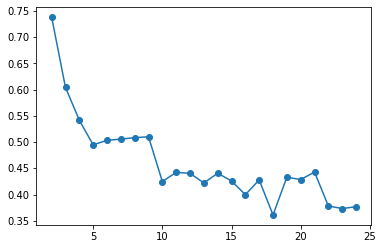

In [184]:
from sklearn.metrics import silhouette_score

score=[]

for k in range(2,25):
    km=KMeans(n_clusters=k)
    res_km=km.fit(data_norm)
    score.append(silhouette_score(data_norm,res_km.labels_))
    
plt.plot(range(2,25),score,marker="o");

# K =5时候 轮廓系数显示较好 簇内紧凑 簇外离散 越大越好 下跌厉害的则效果好
# 下跌不厉害或升高或降低，则K=10或K=11没太大区别效果

## CH轮廓系数方法评估

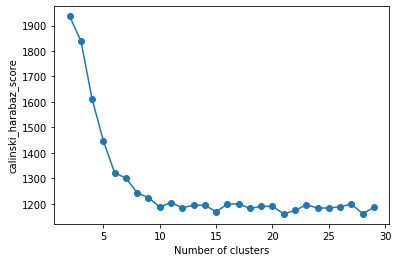

In [188]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# 类别内部数据的协方差越小越好，类别之间的协方差越大越好，这样的Calinski-Harabasz分数会高
# 数值越小可以理解为：组间协方差很小，组与组之间界限不明显
# 得分越大越好，但聚类的点就多了，找一个聚类下降好的K取值 
# 簇点少聚类得分高但分类无意义
# 簇内点多变成一个分类得分就差没做聚类
# 簇得分下降厉害，则K取值效果好，不是很细，也不是很粗

# scikit-learn中， Calinski-Harabasz Index对应的方法是metrics.calinski_harabaz_score
ch_scores = []
for i in range(2, 30):
    km = KMeans(n_clusters=i)
    # init='k-means++',
    # n_init=10,
    # max_iter=300,
    # random_state=0      
    km.fit(data_norm)
    ch_scores.append(metrics.calinski_harabaz_score(data_norm, km.labels_))
plt.plot(range(2,30), ch_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_harabaz_score')
plt.show()

# Kmeans生成用户标签

- 结合sse曲线和CH--SH轮廓系数曲线，选择看=5比较好

In [189]:
km=KMeans(n_clusters=5)
km.fit(data_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 获取km.labels_标签结果

In [190]:
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [191]:
order_tag.head(2)

,价格,购买数量,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,收货人姓名,宝贝总数量,店铺Id,店铺名称,卖家服务费,退款金额
买家会员名,,,,,,,,,,,,,,,
0,9.90,1,9.90,5.0,0,14.90,0,14.90,0,1963,1,0,0,0,0
1,19.83,8,130.24,20.0,0,150.24,0,150.24,0,11072,32,0,0,0,0


In [93]:
pd.Series(km.labels_).value_counts()

0    2403
2     501
3     230
1     113
4      71
dtype: int64

In [192]:
# del order_tag['列表']
order_tag['类别'] = km.labels_
order_tag.head(2)

,价格,购买数量,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,收货人姓名,宝贝总数量,店铺Id,店铺名称,卖家服务费,退款金额,类别
买家会员名,,,,,,,,,,,,,,,,
0,9.90,1,9.90,5.0,0,14.90,0,14.90,0,1963,1,0,0,0,0,0
1,19.83,8,130.24,20.0,0,150.24,0,150.24,0,11072,32,0,0,0,0,0


In [98]:
clusters = order_tag['类别']
clusters.to_csv(r'D:\会员标签.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


# 生成推荐规则

- 推荐系统的策略：

- 推荐给每个客户的产品，都是他没购买过的。
- 在没购买过的产品里面，哪些产品是和他同类客户里面，最受欢迎
- 同类客户里面，购买数量（次数）最多的那款产品，就属于受欢迎产品
- 同类客户里面，平均购买数量（平均购买次数）最多的那款产品，就属于受欢迎的产品


- 买家会员名
- 标题：对应买家没购买过的商品名称
- 类别：对应买家所属的类别
- 购买次数：同类客户对该款产品的平均购买次数（同类客户对该款产品的偏好程度）

## 用户-购买商品次数表

- 用户信息，订单编号信息，在order
- 订单购买过哪些商品，在订单详情表里order_detail

In [194]:
user_items = pd.merge(order,order_detail,how='left',on='订单编号')
user_items.head(2)

,订单编号,买家会员名,买家应付货款,买家应付邮费,买家支付积分,总金额,返点积分,买家实际支付金额,买家实际支付积分,订单状态,...,宝贝种类_49,宝贝种类_5,宝贝种类_50,宝贝种类_6,宝贝种类_7,宝贝种类_8,宝贝种类_9,标题,价格,购买数量
0,21407300627014900,1425,58.51,0.0,0,58.51,0,58.51,0,交易成功,...,0,1,0,0,0,0,0,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,0.58,12
1,21407300627014900,1425,58.51,0.0,0,58.51,0,58.51,0,交易成功,...,0,1,0,0,0,0,0,特价5号AA普通干电池 电动玩具配件 厂家直销批,1.00,20


In [195]:
user_items = user_items[['买家会员名','标题']]
user_items.head(2)

,买家会员名,标题
0,1425,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家
1,1425,特价5号AA普通干电池 电动玩具配件 厂家直销批


In [196]:
user_items["购买次数"]=1
user_items.head(2)

,买家会员名,标题,购买次数
0,1425,发光玩具批发光纤手指灯闪光夜市热卖货源儿童玩具地摊义乌厂家,1
1,1425,特价5号AA普通干电池 电动玩具配件 厂家直销批,1


In [197]:
user_items=user_items.pivot_table("购买次数",index="买家会员名",columns="标题").fillna(0)
user_items.head()

标题,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,2017创意新款惯性工程车 槽罐水泥车汽车男生礼物儿童玩具车批发,2017创意新款拉线110警车好玩的儿童义乌地摊货源热卖玩具车批发,2017创意新款磁性钓鱼玩具 桶装早教益智儿童玩具批发地摊货免邮,2017创意新款音乐枪猴子电动枪满天星发光枪儿童玩具地摊货批发,2017新品创意发条玩具上链嘻哈猴地摊热卖幼儿园礼品儿童玩具批发,...,益智拼装积木玩具卡通动物乐园系列3-6岁儿童早教认知大颗粒积木,磁性钓鱼套装益智儿童钓鱼玩具小猫宝宝钓鱼池洗澡戏水男孩1-3岁,经典发条玩具会跑会跳创意上链发条玩具动物儿童好玩的地摊货批发,美食过家家创意儿童玩具益智早教宝宝礼物女生玩具地摊货热卖批发,苹果磁性写字板画板 热销幼儿园礼品六一节儿童地摊玩具货源批发,过家家切切乐礼盒套装女孩厨房玩具儿童礼物宝宝做饭仿真厨具餐具,过家家厨房玩具仿真小家电电动热卖单只装迷你儿童玩具女孩童创意,迷你儿童玩具推土机工程车新奇特挖机益智儿童幼儿园礼品玩具批发,遥控坦克车越野车玩具军事模型可充电动汽车大炮儿童男孩3-6周岁,遥控警车可充电儿童电动玩具车大方向盘重力感应漂移赛车男孩礼物
买家会员名,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
user_items=user_items.stack().reset_index()
user_items.rename(columns={0:'购买次数'},inplace=True)
user_items.head()

,买家会员名,标题,购买次数
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0


## 用户-未购买商品表

In [199]:
user_items_notbuy=user_items[user_items.购买次数==0]
user_items_notbuy.head(2)

,买家会员名,标题,购买次数
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0


In [200]:
user_items_notbuy.describe().T

,count,mean,std,min,25%,50%,75%,max
买家会员名,1098365.0,1704.921767,984.810587,0.0,852.0,1705.0,2558.0,3410.0
购买次数,1098365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [201]:
user_items_notbuy.reset_index(drop=True,inplace=True)

In [202]:
user_items_notbuy.drop("购买次数",axis=1,inplace=True)
user_items_notbuy.head()

,买家会员名,标题
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖


## 用户-未购买-类群表

In [223]:
clusters=order_tag["类别"]
clusters

买家会员名
0       0
1       0
2       0
3       0
4       0
       ..
3406    3
3407    0
3408    0
3409    0
3410    0
Name: 类别, Length: 3318, dtype: int32

In [224]:
user_itme_notbuy_cluster=pd.merge(user_items_notbuy,clusters,on='买家会员名',how="left")
user_itme_notbuy_cluster.head()

,买家会员名,标题,类别
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0


## 类群-商品-购买次数表

对所有类别的会员，根据购买商品次数的信息，统计出不同类别的会员对哪些商品更加偏好

In [204]:
user_items.head()  

# 记录所有会员对所有商品的购买次数

,买家会员名,标题,购买次数
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0


In [225]:
user_items_num_cluster=pd.merge(user_items,clusters,on="买家会员名",how="left")
user_items_num_cluster.head()

,买家会员名,标题,购买次数,类别
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0,0.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0,0.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0,0.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0,0.0


In [226]:
cluster_item_num=user_items_num_cluster.groupby(["类别","标题"])["购买次数"].sum().reset_index()
cluster_item_num.head()

,类别,标题,购买次数
0,0.0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,5.0
1,0.0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,23.0
2,0.0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,1.0
3,0.0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,36.0
4,0.0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,7.0


##  用户-商品-类别-购买次数表

In [227]:
user_itme_notbuy_cluster.head()

,买家会员名,标题,类别
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0


In [228]:
cluster_item_num.head()

,类别,标题,购买次数
0,0.0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,5.0
1,0.0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,23.0
2,0.0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,1.0
3,0.0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,36.0
4,0.0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,7.0


In [229]:
user_notbuy_num=pd.merge(user_itme_notbuy_cluster,cluster_item_num,on=["类别","标题"],how="left")
user_notbuy_num.head()

,买家会员名,标题,类别,购买次数
0,0,0-1岁婴幼儿摇铃3-6个月宝宝拼接动物手摇铃牙胶男女孩玩具袋装,0.0,5.0
1,0,10元以下儿童小玩具批发创意棒棒糖发光棒女孩闪光棒夜市地摊货源,0.0,23.0
2,0,2017创意发光玩具七彩闪光飞轮拉哨旋转男孩儿童玩具地摊货源批发,0.0,1.0
3,0,2017创意台球桌小玩具儿童礼物男孩义乌玩具批发地摊货源免邮好玩,0.0,36.0
4,0,2017创意惯性工程车推土机男孩儿童玩具车批发新奇礼物地摊热卖,0.0,7.0


# 新增列生成推荐指数

In [220]:
def topk(x):
    res=x.sort_values('购买次数',ascending=False)[:5]
    res["推荐指数"]=[5,4,3,2,1]
    return res

In [230]:
recom=user_notbuy_num.groupby("买家会员名").apply(topk)
recom.head()

买家会员名                                标题   类别   购买次数  推荐指数
买家会员名                                                               
0     165      0    创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发  0.0  208.0     5
      123      0    创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发  0.0  165.0     4
      148      0     创意恐龙玩具卡装仿真恐龙模型小孩礼物宝宝玩具地摊货批发免邮  0.0  124.0     3
      15       0  2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发  0.0  113.0     2
      141      0    创意婴幼儿学习故事机小兔子早教玩具儿童益智地摊货小孩玩具批发  0.0  113.0     1

In [231]:
recom.reset_index(drop=True,inplace=True)

In [232]:
recom.head()

,买家会员名,标题,类别,购买次数,推荐指数
0,0,创意新款发光翅膀背带儿童演出服装天使蝴蝶翅膀地摊货源玩具批发,0.0,208.0,5
1,0,创意发光球闪光透明发光水晶弹力球儿童小玩具 夜市地摊货源批发,0.0,165.0,4
2,0,创意恐龙玩具卡装仿真恐龙模型小孩礼物宝宝玩具地摊货批发免邮,0.0,124.0,3
3,0,2017热卖大号仿真惯性挖土机儿童益智礼品创意义乌地摊货玩具批发,0.0,113.0,2
4,0,创意婴幼儿学习故事机小兔子早教玩具儿童益智地摊货小孩玩具批发,0.0,113.0,1


In [ ]:
recom.to_excel("客户商品推荐列表top5.xlsx")